# Sentiment Analysis to predict stock price direction using Classifier models

## 1. Introduction
A selection of machine learning classifier models will be used to predict whether the next day Adjusted Close price of AstraZeneca stock will increase or decrease based on sentiment analysis of market news articles from 2014-2021 collected by web scraping from [Investing.com](https://uk.investing.com/equities/astrazeneca-news). 

Sentiment Analysis is the use of NLP, text analysis and
computational linguistics to determine subjective information. Instead of building our own lexicon to do this, we will use VADER (Valence Aware Dictionary and sEntiment Reasoner), a pre-trained sentiment analysis model included in the NLTK package. We will also use TextBlob, a simple API built upon NLTK, for common NLP tasks.



## 2. Install/import libraries

In [ ]:
!pip install yfinance
!pip install htmldate
!pip install twython
!pip3 install newspaper3k

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import seaborn as sns
import math
import datetime
import time
import re
import yfinance as yf
import twython
import requests
import nltk
import warnings
warnings.filterwarnings('ignore')

from htmldate import find_date
from datetime import date, timedelta
from tqdm import tqdm
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
from newspaper import Article
from textblob import TextBlob

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

## 3. Import data for sentiment analysis

Dynamic web scraping to collect news for sentiment analysis using a combination of Selenium library to automate browser interaction enabling data extraction by Beautiful Soup. 

In [ ]:
!pip install selenium
!apt-get update 
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

In [ ]:
def get_newslinks(company, page_number):
    
    url = f"https://uk.investing.com/equities/{company}-news/{page_number}"
    driver.get(url)

    href = []

        # scroll all the way to the bottom 

    old_position = 0
    new_position = None

    while new_position != old_position:
        # Get old scroll position
        old_position = driver.execute_script(
                ("return (window.pageYOffset !== undefined) ?"
                " window.pageYOffset : (document.documentElement ||"
                " document.body.parentNode || document.body);"))
        # Sleep and Scroll
        time.sleep(1)
        driver.execute_script((
                "var scrollingElement = (document.scrollingElement ||"
                " document.body);scrollingElement.scrollTop ="
                " scrollingElement.scrollHeight;"))
        # Get new position
        new_position = driver.execute_script(
                ("return (window.pageYOffset !== undefined) ?"
                " window.pageYOffset : (document.documentElement ||"
                " document.body.parentNode || document.body);"))
        
    cleaned_links = []


    for article_number in range(1,11): 
        article = driver.find_element_by_xpath(f'/html/body/div[5]/section/div[8]/article[{article_number}]')
        article_html = article.get_attribute('innerHTML')
        soup = BeautifulSoup(article_html, "lxml")
        for link in soup.find_all('a'): 
            partial_link = link.get('href')
            if 'https' in partial_link: 
                cleaned_links.append(partial_link)
            elif partial_link[0] == '/': 
                cleaned_links.append('https://uk.investing.com/'+partial_link) 

    return np.unique(cleaned_links)

In [ ]:
# Create empty list to append URLs 

all_company_urls = []
for page in range(1,119):
    results = get_newslinks('astrazeneca', page)
    all_company_urls.extend(results)
all_company_urls

['https://invst.ly/tb-6x',
 'https://invst.ly/tb-n4',
 'https://invst.ly/tbon0',
 'https://invst.ly/tbxxc',
 'https://invst.ly/tbyb8',
 'https://invst.ly/tbzzy',
 'https://invst.ly/tc0ay',
 'https://invst.ly/tc2id',
 'https://invst.ly/tcjd5',
 'https://uk.investing.com//news/stock-market-news/uk-stocksfactors-to-watch-on-jan-4-2274638',
 'https://invst.ly/ta-bv',
 'https://invst.ly/tavnc',
 'https://invst.ly/tavzk',
 'https://invst.ly/tazh-',
 'https://invst.ly/tb0n-',
 'https://invst.ly/tb0po',
 'https://invst.ly/tb0pu',
 'https://invst.ly/tbgq4',
 'https://uk.investing.com//news/stock-market-news/uk-stocksfactors-to-watch-on-dec-31-2273851',
 'https://invst.ly/tao66',
 'https://invst.ly/tapfh',
 'https://invst.ly/tapq5',
 'https://invst.ly/taq6h',
 'https://invst.ly/tar6p',
 'https://invst.ly/tara2',
 'https://invst.ly/targ5',
 'https://invst.ly/tatz3',
 'https://invst.ly/tav9t',
 'https://uk.investing.com//news/economy/asian-shares-pause-recent-rally-euro-near-212year-high-2273311',

In [ ]:
# Loop over all the articles 

ticker = 'AZN.L'
# Create a DataFrame to populate while iterating
article_sentiments = pd.DataFrame({'ticker':[],
                                'publish_date':[],
                                'title': [],
                                'body_text': [],
                                'url':[],
                                'neg':[],
                                'neu':[], 
                                'pos':[], 
                                'compound':[]})
 
for link in all_company_urls:
      article = Article(link)
      article.download()
      
      try:
          article.parse()
          text = article.text

      except: 
          print("I didn't get this")
          continue

      # Initialise sentiment analyser    
      sid = SentimentIntensityAnalyzer()
      # Get positive, negative, neutral and compound scores
      polarity = sid.polarity_scores(text)

      tmpdic = {'ticker': ticker, 'publish_date': find_date(link), 'title': article.title, 'body_text': article.text, 'url': link}
      # Update ticker with the new entry polarity
      tmpdic.update(polarity)
      # tmpdic now has all keys and values needed to populate the DataFrame
      article_sentiments= article_sentiments.append(pd.DataFrame(tmpdic, index=[0]))
      article_sentiments.reset_index(drop=True, inplace=True)

I didn't get this
I didn't get this
I didn't get this
I didn't get this
I didn't get this
I didn't get this
I didn't get this


In [ ]:
# Show DataFrame of article sentiments data

article_sentiments

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
0,AZN.L,2021-01-04,Coronavirus: UK starts rollout of AstraZeneca/...,"The FTSE 100 firm has provided 530,000 doses r...",https://invst.ly/tb-6x,0.020,0.877,0.103,0.9796
1,AZN.L,None,Optimism continues into new year as European s...,"European stocks rose on Monday, with investors...",https://invst.ly/tb-n4,0.037,0.877,0.086,0.9545
2,AZN.L,2021-01-03,AstraZeneca’s COVID-19 Vaccine Wins Emergency ...,The COVID-19 vaccine developed by AstraZeneca ...,https://invst.ly/tbon0,0.031,0.859,0.110,0.9769
3,AZN.L,2021-01-04,AstraZeneca completes sale of heart failure tr...,The buyer is German pharma company Cheplapharm...,https://invst.ly/tbxxc,0.038,0.907,0.055,0.5859
4,AZN.L,2021-01-04,UK rolls out Oxford-AstraZeneca vaccine as it ...,LONDON — The U.K. has started rolling out the ...,https://invst.ly/tbyb8,0.018,0.928,0.054,0.9247
...,...,...,...,...,...,...,...,...,...
1209,AZN.L,2014-04-30,"GSK says staying on sidelines in Astra, Pfizer...",By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...,https://uk.investing.com//news/stock-market-ne...,0.021,0.805,0.174,0.9972
1210,AZN.L,2014-05-01,Pfizer prepares sweeter bid for AstraZeneca - ...,Pfizer prepares sweeter bid for AstraZeneca - ...,https://uk.investing.com//news/stock-market-ne...,0.011,0.942,0.048,0.5274
1211,AZN.L,2014-05-01,Pfizer’s designs on AstraZeneca stir tax envy ...,By Olivia Oran and Soyoung Kim\n\nNEW YORK (Re...,https://uk.investing.com//news/stock-market-ne...,0.038,0.910,0.052,0.8085
1212,AZN.L,2014-05-01,R&D site marks political frontline in $100 bil...,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...,https://uk.investing.com//news/stock-market-ne...,0.060,0.831,0.109,0.9920


In [ ]:
# Save DataFrame 

article_sentiments.to_pickle("azn_article_sentiments_20210105.pkl")

In [ ]:
article_sentiments.to_csv("azn_article_sentiments_20210105.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
# Save URLS to text file

with open('azn_urls_20210105.txt', 'w') as f:
    for link in all_company_urls:
        f.write("%s\n" % link)

In [ ]:
# Create copy of DataFrame

article_sentiments_azn = article_sentiments.copy()
article_sentiments_azn.head(5)

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
0,AZN.L,2021-01-04,Coronavirus: UK starts rollout of AstraZeneca/...,"The FTSE 100 firm has provided 530,000 doses r...",https://invst.ly/tb-6x,0.020,0.877,0.103,0.9796
1,AZN.L,None,Optimism continues into new year as European s...,"European stocks rose on Monday, with investors...",https://invst.ly/tb-n4,0.037,0.877,0.086,0.9545
2,AZN.L,2021-01-03,AstraZeneca’s COVID-19 Vaccine Wins Emergency ...,The COVID-19 vaccine developed by AstraZeneca ...,https://invst.ly/tbon0,0.031,0.859,0.110,0.9769
3,AZN.L,2021-01-04,AstraZeneca completes sale of heart failure tr...,The buyer is German pharma company Cheplapharm...,https://invst.ly/tbxxc,0.038,0.907,0.055,0.5859
4,AZN.L,2021-01-04,UK rolls out Oxford-AstraZeneca vaccine as it ...,LONDON — The U.K. has started rolling out the ...,https://invst.ly/tbyb8,0.018,0.928,0.054,0.9247


## 4. Clean news data

Prepare data for further processing by appending separator to body text of each article.

In [ ]:
# Append ---newarticle--- to split for NLP

article_sentiments_azn['body_text'] = article_sentiments_azn['body_text'].astype(str) + '---newarticle---'

In [ ]:
azn_bodytext = article_sentiments_azn['body_text']
azn_bodytext

0       The FTSE 100 firm has provided 530,000 doses r...
1       European stocks rose on Monday, with investors...
2       The COVID-19 vaccine developed by AstraZeneca ...
3       The buyer is German pharma company Cheplapharm...
4       LONDON — The U.K. has started rolling out the ...
                              ...                        
1209    By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...
1210    Pfizer prepares sweeter bid for AstraZeneca - ...
1211    By Olivia Oran and Soyoung Kim\n\nNEW YORK (Re...
1212    By Ben Hirschler\n\nCAMBRIDGE England (Reuters...
1213    LONDON (Reuters) - The British government said...
Name: body_text, Length: 1214, dtype: object

In [ ]:
pd.set_option("display.max_colwidth", -1)  # to display full text
azn_bodytext

0       The FTSE 100 firm has provided 530,000 doses ready for use on Monday at six hospital trusts\n\nThe UK has begun the rollout of the coronavirus (COVID-19) vaccine produced by PLC ( ) and Oxford University.\n\nThe FTSE 100 firm has provided 530,000 doses ready for use on Monday at six hospital trusts, in Oxford, London, Sussex, Lancashire and Warwickshire.\n\nMost other available doses will be sent to GP-led services and care homes later in the week.\n\n'I'm so pleased to be getting the COVID vaccine today and really proud it is one that was invented in Oxford.'\n\n\n\n82-year-old Brian Pinker became the first person in the world to receive the new Oxford vaccine this morning at @OUHospitals. ???? pic.twitter.com/nhnd3Sx97m — NHS England and NHS Improvement (@NHSEngland) January 4, 2021\n\nThe country has established over 730 vaccination sites and hundreds more are opening this week to take the total to over 1,000.\n\nThe government has secured access to 100mln doses of the inocu

In [ ]:
# Save article_sentiments_azn to txt

with open('azn_bodytext_20210105.txt', 'w') as f:
    f.write(
        azn_bodytext.to_string(header = False, index = False)
    )

### Remove spaces in text file

In [ ]:
# first get all lines from file
with open('azn_bodytext_20210105.txt', 'r') as f:
    lines = f.readlines()

# remove spaces
lines = [line.replace(' ', '') for line in lines]

# finally, write lines in the file
with open('azn_bodytext_20210105.txt', 'w') as f:
    f.writelines(lines)

### Remove end line breaks from text file

In [ ]:
# first get all lines from file
a_file = open("azn_bodytext_20210105.txt", "r")

# create variable for string without line breaks
string_without_line_breaks = ""

# iterate over strings 
for line in a_file:
  stripped_line = line.rstrip() # rstrip() method removes any trailing characters - space is the default trailing character to remove
  string_without_line_breaks += stripped_line
a_file.close()

In [ ]:
# finally, write lines in the file
with open('azn_bodytext_20210105.txt', 'w') as f:
    f.writelines(string_without_line_breaks)

In [ ]:
# Read article sentiments data into DataFrame 

azn_news_df = pd.read_pickle('azn_article_sentiments_20210105.pkl') 
azn_news_df

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
0,AZN.L,2021-01-04,Coronavirus: UK starts rollout of AstraZeneca/...,"The FTSE 100 firm has provided 530,000 doses r...",https://invst.ly/tb-6x,0.020,0.877,0.103,0.9796
1,AZN.L,None,Optimism continues into new year as European s...,"European stocks rose on Monday, with investors...",https://invst.ly/tb-n4,0.037,0.877,0.086,0.9545
2,AZN.L,2021-01-03,AstraZeneca’s COVID-19 Vaccine Wins Emergency ...,The COVID-19 vaccine developed by AstraZeneca ...,https://invst.ly/tbon0,0.031,0.859,0.110,0.9769
3,AZN.L,2021-01-04,AstraZeneca completes sale of heart failure tr...,The buyer is German pharma company Cheplapharm...,https://invst.ly/tbxxc,0.038,0.907,0.055,0.5859
4,AZN.L,2021-01-04,UK rolls out Oxford-AstraZeneca vaccine as it ...,LONDON — The U.K. has started rolling out the ...,https://invst.ly/tbyb8,0.018,0.928,0.054,0.9247
...,...,...,...,...,...,...,...,...,...
1209,AZN.L,2014-04-30,"GSK says staying on sidelines in Astra, Pfizer...",By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...,https://uk.investing.com//news/stock-market-ne...,0.021,0.805,0.174,0.9972
1210,AZN.L,2014-05-01,Pfizer prepares sweeter bid for AstraZeneca - ...,Pfizer prepares sweeter bid for AstraZeneca - ...,https://uk.investing.com//news/stock-market-ne...,0.011,0.942,0.048,0.5274
1211,AZN.L,2014-05-01,Pfizer’s designs on AstraZeneca stir tax envy ...,By Olivia Oran and Soyoung Kim\n\nNEW YORK (Re...,https://uk.investing.com//news/stock-market-ne...,0.038,0.910,0.052,0.8085
1212,AZN.L,2014-05-01,R&D site marks political frontline in $100 bil...,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...,https://uk.investing.com//news/stock-market-ne...,0.060,0.831,0.109,0.9920


In [ ]:
# Check data types

azn_news_df.dtypes

ticker           object
publish_date     object
title            object
body_text        object
url              object
neg             float64
neu             float64
pos             float64
compound        float64
dtype: object

In [ ]:
# Create copy of DataFrame

azn_news_df_new = azn_news_df.copy()

### Drop rows without publish date

In [ ]:
# Drop rows with None in publish_date column

azn_news_df_new = azn_news_df_new.replace(to_replace='None', value=np.nan).dropna()
azn_news_df_new

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
0,AZN.L,2021-01-04,Coronavirus: UK starts rollout of AstraZeneca/...,"The FTSE 100 firm has provided 530,000 doses r...",https://invst.ly/tb-6x,0.020,0.877,0.103,0.9796
2,AZN.L,2021-01-03,AstraZeneca’s COVID-19 Vaccine Wins Emergency ...,The COVID-19 vaccine developed by AstraZeneca ...,https://invst.ly/tbon0,0.031,0.859,0.110,0.9769
3,AZN.L,2021-01-04,AstraZeneca completes sale of heart failure tr...,The buyer is German pharma company Cheplapharm...,https://invst.ly/tbxxc,0.038,0.907,0.055,0.5859
4,AZN.L,2021-01-04,UK rolls out Oxford-AstraZeneca vaccine as it ...,LONDON — The U.K. has started rolling out the ...,https://invst.ly/tbyb8,0.018,0.928,0.054,0.9247
8,AZN.L,2021-01-05,The UK is delaying second vaccine shots and it...,Medical personnel is given the Pfizer-Biontech...,https://invst.ly/tcjd5,0.046,0.909,0.045,0.1308
...,...,...,...,...,...,...,...,...,...
1209,AZN.L,2014-04-30,"GSK says staying on sidelines in Astra, Pfizer...",By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...,https://uk.investing.com//news/stock-market-ne...,0.021,0.805,0.174,0.9972
1210,AZN.L,2014-05-01,Pfizer prepares sweeter bid for AstraZeneca - ...,Pfizer prepares sweeter bid for AstraZeneca - ...,https://uk.investing.com//news/stock-market-ne...,0.011,0.942,0.048,0.5274
1211,AZN.L,2014-05-01,Pfizer’s designs on AstraZeneca stir tax envy ...,By Olivia Oran and Soyoung Kim\n\nNEW YORK (Re...,https://uk.investing.com//news/stock-market-ne...,0.038,0.910,0.052,0.8085
1212,AZN.L,2014-05-01,R&D site marks political frontline in $100 bil...,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...,https://uk.investing.com//news/stock-market-ne...,0.060,0.831,0.109,0.9920


### Drop rows with duplicate titles

In [ ]:
# Dropping all duplicate titles keeping only the first instance

azn_news_df_new.drop_duplicates(subset ="title", 
                     keep = 'first', inplace = True)

azn_news_df_new

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
0,AZN.L,2021-01-04,Coronavirus: UK starts rollout of AstraZeneca/...,"The FTSE 100 firm has provided 530,000 doses r...",https://invst.ly/tb-6x,0.020,0.877,0.103,0.9796
2,AZN.L,2021-01-03,AstraZeneca’s COVID-19 Vaccine Wins Emergency ...,The COVID-19 vaccine developed by AstraZeneca ...,https://invst.ly/tbon0,0.031,0.859,0.110,0.9769
3,AZN.L,2021-01-04,AstraZeneca completes sale of heart failure tr...,The buyer is German pharma company Cheplapharm...,https://invst.ly/tbxxc,0.038,0.907,0.055,0.5859
4,AZN.L,2021-01-04,UK rolls out Oxford-AstraZeneca vaccine as it ...,LONDON — The U.K. has started rolling out the ...,https://invst.ly/tbyb8,0.018,0.928,0.054,0.9247
8,AZN.L,2021-01-05,The UK is delaying second vaccine shots and it...,Medical personnel is given the Pfizer-Biontech...,https://invst.ly/tcjd5,0.046,0.909,0.045,0.1308
...,...,...,...,...,...,...,...,...,...
1209,AZN.L,2014-04-30,"GSK says staying on sidelines in Astra, Pfizer...",By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...,https://uk.investing.com//news/stock-market-ne...,0.021,0.805,0.174,0.9972
1210,AZN.L,2014-05-01,Pfizer prepares sweeter bid for AstraZeneca - ...,Pfizer prepares sweeter bid for AstraZeneca - ...,https://uk.investing.com//news/stock-market-ne...,0.011,0.942,0.048,0.5274
1211,AZN.L,2014-05-01,Pfizer’s designs on AstraZeneca stir tax envy ...,By Olivia Oran and Soyoung Kim\n\nNEW YORK (Re...,https://uk.investing.com//news/stock-market-ne...,0.038,0.910,0.052,0.8085
1212,AZN.L,2014-05-01,R&D site marks political frontline in $100 bil...,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...,https://uk.investing.com//news/stock-market-ne...,0.060,0.831,0.109,0.9920


### Set datetime index

In [ ]:
# Set string representation of date to datetime index

azn_news_df_new['Date'] = pd.to_datetime(azn_news_df_new.publish_date)
azn_news_df_new.set_index('Date', inplace=True)
azn_news_df_new

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
Date,,,,,,,,,
2021-01-04,AZN.L,2021-01-04,Coronavirus: UK starts rollout of AstraZeneca/...,"The FTSE 100 firm has provided 530,000 doses r...",https://invst.ly/tb-6x,0.020,0.877,0.103,0.9796
2021-01-03,AZN.L,2021-01-03,AstraZeneca’s COVID-19 Vaccine Wins Emergency ...,The COVID-19 vaccine developed by AstraZeneca ...,https://invst.ly/tbon0,0.031,0.859,0.110,0.9769
2021-01-04,AZN.L,2021-01-04,AstraZeneca completes sale of heart failure tr...,The buyer is German pharma company Cheplapharm...,https://invst.ly/tbxxc,0.038,0.907,0.055,0.5859
2021-01-04,AZN.L,2021-01-04,UK rolls out Oxford-AstraZeneca vaccine as it ...,LONDON — The U.K. has started rolling out the ...,https://invst.ly/tbyb8,0.018,0.928,0.054,0.9247
2021-01-05,AZN.L,2021-01-05,The UK is delaying second vaccine shots and it...,Medical personnel is given the Pfizer-Biontech...,https://invst.ly/tcjd5,0.046,0.909,0.045,0.1308
...,...,...,...,...,...,...,...,...,...
2014-04-30,AZN.L,2014-04-30,"GSK says staying on sidelines in Astra, Pfizer...",By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...,https://uk.investing.com//news/stock-market-ne...,0.021,0.805,0.174,0.9972
2014-05-01,AZN.L,2014-05-01,Pfizer prepares sweeter bid for AstraZeneca - ...,Pfizer prepares sweeter bid for AstraZeneca - ...,https://uk.investing.com//news/stock-market-ne...,0.011,0.942,0.048,0.5274
2014-05-01,AZN.L,2014-05-01,Pfizer’s designs on AstraZeneca stir tax envy ...,By Olivia Oran and Soyoung Kim\n\nNEW YORK (Re...,https://uk.investing.com//news/stock-market-ne...,0.038,0.910,0.052,0.8085


In [ ]:
# Show dateime index of new DataFrame

azn_news_df_new.index

DatetimeIndex(['2021-01-04', '2021-01-03', '2021-01-04', '2021-01-04',
               '2021-01-05', '2021-01-04', '2020-12-31', '2020-12-31',
               '2020-12-30', '2020-12-30',
               ...
               '2014-05-05', '2014-05-02', '2014-05-01', '2014-05-02',
               '2014-05-02', '2014-04-30', '2014-05-01', '2014-05-01',
               '2014-05-01', '2014-05-02'],
              dtype='datetime64[ns]', name='Date', length=973, freq=None)

### Sort in ascending chronological order

In [ ]:
# Sort in chronological order

azn_news_df_new = azn_news_df_new.sort_index()
azn_news_df_new

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound
Date,,,,,,,,,
2014-04-30,AZN.L,2014-04-30,"GSK says staying on sidelines in Astra, Pfizer...",By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...,https://uk.investing.com//news/stock-market-ne...,0.021,0.805,0.174,0.9972
2014-05-01,AZN.L,2014-05-01,R&D site marks political frontline in $100 bil...,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...,https://uk.investing.com//news/stock-market-ne...,0.060,0.831,0.109,0.9920
2014-05-01,AZN.L,2014-05-01,Pfizer’s designs on AstraZeneca stir tax envy ...,By Olivia Oran and Soyoung Kim\n\nNEW YORK (Re...,https://uk.investing.com//news/stock-market-ne...,0.038,0.910,0.052,0.8085
2014-05-01,AZN.L,2014-05-01,Pfizer prepares sweeter bid for AstraZeneca - ...,Pfizer prepares sweeter bid for AstraZeneca - ...,https://uk.investing.com//news/stock-market-ne...,0.011,0.942,0.048,0.5274
2014-05-01,AZN.L,2014-05-01,"Astra, Pfizer deal could face Chinese antitrus...",By Ben Hirschler\n\nLONDON (Reuters) - Pfizer'...,https://uk.investing.com//news/stock-market-ne...,0.068,0.866,0.066,-0.0935
...,...,...,...,...,...,...,...,...,...
2021-01-04,AZN.L,2021-01-04,UK Stocks-Factors to watch on Jan. 4,© Reuters.\n\nJan 4 (Reuters) - Britain's FTSE...,https://uk.investing.com//news/stock-market-ne...,0.076,0.868,0.056,-0.9072
2021-01-04,AZN.L,2021-01-04,UK rolls out Oxford-AstraZeneca vaccine as it ...,LONDON — The U.K. has started rolling out the ...,https://invst.ly/tbyb8,0.018,0.928,0.054,0.9247
2021-01-04,AZN.L,2021-01-04,AstraZeneca completes sale of heart failure tr...,The buyer is German pharma company Cheplapharm...,https://invst.ly/tbxxc,0.038,0.907,0.055,0.5859


In [ ]:
# Save sorted DataFrame 

azn_news_df_new.to_pickle("azn_news_df_new_20210106.pkl")

In [ ]:
azn_news_df_new.to_csv("azn_news_df_new_20210106.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
#azn_news_df_new.dtypes

ticker           object
publish_date     object
title            object
body_text        object
url              object
neg             float64
neu             float64
pos             float64
compound        float64
dtype: object

In [ ]:
# Create copy of DataFrame 

azn_news_df_combined = azn_news_df_new.copy()

### Combine articles published on same date

Combine all news articles published on same date to get a single score. An alternative method could be to take the mean score of all articles published on the same date.

In [ ]:
# Combining all the news published on a single date in a separate column

azn_news_df_combined['news_combined'] = azn_news_df_combined.groupby(['publish_date'])['body_text'].transform(lambda x: ' '.join(x))

azn_news_df_combined

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound,news_combined
Date,,,,,,,,,,
2014-04-30,AZN.L,2014-04-30,"GSK says staying on sidelines in Astra, Pfizer...",By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...,https://uk.investing.com//news/stock-market-ne...,0.021,0.805,0.174,0.9972,By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...
2014-05-01,AZN.L,2014-05-01,R&D site marks political frontline in $100 bil...,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...,https://uk.investing.com//news/stock-market-ne...,0.060,0.831,0.109,0.9920,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...
2014-05-01,AZN.L,2014-05-01,Pfizer’s designs on AstraZeneca stir tax envy ...,By Olivia Oran and Soyoung Kim\n\nNEW YORK (Re...,https://uk.investing.com//news/stock-market-ne...,0.038,0.910,0.052,0.8085,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...
2014-05-01,AZN.L,2014-05-01,Pfizer prepares sweeter bid for AstraZeneca - ...,Pfizer prepares sweeter bid for AstraZeneca - ...,https://uk.investing.com//news/stock-market-ne...,0.011,0.942,0.048,0.5274,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...
2014-05-01,AZN.L,2014-05-01,"Astra, Pfizer deal could face Chinese antitrus...",By Ben Hirschler\n\nLONDON (Reuters) - Pfizer'...,https://uk.investing.com//news/stock-market-ne...,0.068,0.866,0.066,-0.0935,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...
...,...,...,...,...,...,...,...,...,...,...
2021-01-04,AZN.L,2021-01-04,UK Stocks-Factors to watch on Jan. 4,© Reuters.\n\nJan 4 (Reuters) - Britain's FTSE...,https://uk.investing.com//news/stock-market-ne...,0.076,0.868,0.056,-0.9072,© Reuters.\n\nJan 4 (Reuters) - Britain's FTSE...
2021-01-04,AZN.L,2021-01-04,UK rolls out Oxford-AstraZeneca vaccine as it ...,LONDON — The U.K. has started rolling out the ...,https://invst.ly/tbyb8,0.018,0.928,0.054,0.9247,© Reuters.\n\nJan 4 (Reuters) - Britain's FTSE...
2021-01-04,AZN.L,2021-01-04,AstraZeneca completes sale of heart failure tr...,The buyer is German pharma company Cheplapharm...,https://invst.ly/tbxxc,0.038,0.907,0.055,0.5859,© Reuters.\n\nJan 4 (Reuters) - Britain's FTSE...


### Drop rows with duplicate dates

In [ ]:
# Dropping duplicate dates keeping only the first instance

azn_news_df_combined.drop_duplicates(subset ="publish_date", 
                     keep = 'first', inplace = True)

In [ ]:
# Show DataFrame to check that the number of rows has decreased

azn_news_df_combined

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound,news_combined
Date,,,,,,,,,,
2014-04-30,AZN.L,2014-04-30,"GSK says staying on sidelines in Astra, Pfizer...",By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...,https://uk.investing.com//news/stock-market-ne...,0.021,0.805,0.174,0.9972,By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...
2014-05-01,AZN.L,2014-05-01,R&D site marks political frontline in $100 bil...,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...,https://uk.investing.com//news/stock-market-ne...,0.060,0.831,0.109,0.9920,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...
2014-05-02,AZN.L,2014-05-02,Astrazeneca rejects latest Pfizer approach,Astrazeneca rejects latest Pfizer approach\n\n...,https://uk.investing.com//news/stock-market-ne...,0.172,0.782,0.047,-0.9169,Astrazeneca rejects latest Pfizer approach\n\n...
2014-05-03,AZN.L,2014-05-03,Analysis - Pfizer U.S research jobs jeopardise...,By Ransdell Pierson and Bill Berkrot\n\nNEW YO...,https://uk.investing.com//news/stock-market-ne...,0.072,0.870,0.057,-0.9436,By Ransdell Pierson and Bill Berkrot\n\nNEW YO...
2014-05-04,AZN.L,2014-05-04,Big Pharma stands to profit by cleaning out it...,By Ransdell Pierson\n\nNEW YORK (Reuters) - Le...,https://uk.investing.com//news/stock-market-ne...,0.045,0.850,0.104,0.9947,By Ransdell Pierson\n\nNEW YORK (Reuters) - Le...
...,...,...,...,...,...,...,...,...,...,...
2020-12-30,AZN.L,2020-12-30,The Daily Biotech Pulse: Osmotica Faces Second...,Here's a roundup of top developments in the bi...,https://invst.ly/tao66,0.036,0.862,0.102,0.9961,Here's a roundup of top developments in the bi...
2020-12-31,AZN.L,2020-12-31,UK Stocks-Factors to watch on Dec 31,© Reuters.\n\nDec 31 (Reuters) - Britain's FTS...,https://uk.investing.com//news/stock-market-ne...,0.057,0.824,0.119,0.9625,© Reuters.\n\nDec 31 (Reuters) - Britain's FTS...
2021-01-03,AZN.L,2021-01-03,AstraZeneca’s COVID-19 Vaccine Wins Emergency ...,The COVID-19 vaccine developed by AstraZeneca ...,https://invst.ly/tbon0,0.031,0.859,0.110,0.9769,The COVID-19 vaccine developed by AstraZeneca ...


In [ ]:
# Save combined DataFrame without duplicates

azn_news_df_combined.to_csv("azn_news_df_combined_20210106.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
azn_news_df_combined = pd.read_csv("azn_news_df_combined_20210106.csv")
azn_news_df_combined.head()

,Date,ticker,publish_date,title,body_text,url,neg,neu,pos,compound,news_combined
0,2014-04-30,AZN.L,2014-04-30,"GSK says staying on sidelines in Astra, Pfizer...",By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...,https://uk.investing.com//news/stock-market-ne...,0.021,0.805,0.174,0.9972,By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...
1,2014-05-01,AZN.L,2014-05-01,R&D site marks political frontline in $100 bil...,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...,https://uk.investing.com//news/stock-market-ne...,0.060,0.831,0.109,0.9920,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...
2,2014-05-02,AZN.L,2014-05-02,Astrazeneca rejects latest Pfizer approach,Astrazeneca rejects latest Pfizer approach\n\n...,https://uk.investing.com//news/stock-market-ne...,0.172,0.782,0.047,-0.9169,Astrazeneca rejects latest Pfizer approach\n\n...
3,2014-05-03,AZN.L,2014-05-03,Analysis - Pfizer U.S research jobs jeopardise...,By Ransdell Pierson and Bill Berkrot\n\nNEW YO...,https://uk.investing.com//news/stock-market-ne...,0.072,0.870,0.057,-0.9436,By Ransdell Pierson and Bill Berkrot\n\nNEW YO...
4,2014-05-04,AZN.L,2014-05-04,Big Pharma stands to profit by cleaning out it...,By Ransdell Pierson\n\nNEW YORK (Reuters) - Le...,https://uk.investing.com//news/stock-market-ne...,0.045,0.850,0.104,0.9947,By Ransdell Pierson\n\nNEW YORK (Reuters) - Le...


### Set datetime index

In [ ]:
# Set string representation of date to datetime index

azn_news_df_combined['Date'] = pd.to_datetime(azn_news_df_combined.publish_date)
azn_news_df_combined.set_index('Date', inplace=True)
azn_news_df_combined

,ticker,publish_date,title,body_text,url,neg,neu,pos,compound,news_combined
Date,,,,,,,,,,
2014-04-30,AZN.L,2014-04-30,"GSK says staying on sidelines in Astra, Pfizer...",By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...,https://uk.investing.com//news/stock-market-ne...,0.021,0.805,0.174,0.9972,By Ben Hirschler\n\nLONDON (Reuters) - GlaxoSm...
2014-05-01,AZN.L,2014-05-01,R&D site marks political frontline in $100 bil...,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...,https://uk.investing.com//news/stock-market-ne...,0.060,0.831,0.109,0.9920,By Ben Hirschler\n\nCAMBRIDGE England (Reuters...
2014-05-02,AZN.L,2014-05-02,Astrazeneca rejects latest Pfizer approach,Astrazeneca rejects latest Pfizer approach\n\n...,https://uk.investing.com//news/stock-market-ne...,0.172,0.782,0.047,-0.9169,Astrazeneca rejects latest Pfizer approach\n\n...
2014-05-03,AZN.L,2014-05-03,Analysis - Pfizer U.S research jobs jeopardise...,By Ransdell Pierson and Bill Berkrot\n\nNEW YO...,https://uk.investing.com//news/stock-market-ne...,0.072,0.870,0.057,-0.9436,By Ransdell Pierson and Bill Berkrot\n\nNEW YO...
2014-05-04,AZN.L,2014-05-04,Big Pharma stands to profit by cleaning out it...,By Ransdell Pierson\n\nNEW YORK (Reuters) - Le...,https://uk.investing.com//news/stock-market-ne...,0.045,0.850,0.104,0.9947,By Ransdell Pierson\n\nNEW YORK (Reuters) - Le...
...,...,...,...,...,...,...,...,...,...,...
2020-12-30,AZN.L,2020-12-30,The Daily Biotech Pulse: Osmotica Faces Second...,Here's a roundup of top developments in the bi...,https://invst.ly/tao66,0.036,0.862,0.102,0.9961,Here's a roundup of top developments in the bi...
2020-12-31,AZN.L,2020-12-31,UK Stocks-Factors to watch on Dec 31,© Reuters.\n\nDec 31 (Reuters) - Britain's FTS...,https://uk.investing.com//news/stock-market-ne...,0.057,0.824,0.119,0.9625,© Reuters.\n\nDec 31 (Reuters) - Britain's FTS...
2021-01-03,AZN.L,2021-01-03,AstraZeneca’s COVID-19 Vaccine Wins Emergency ...,The COVID-19 vaccine developed by AstraZeneca ...,https://invst.ly/tbon0,0.031,0.859,0.110,0.9769,The COVID-19 vaccine developed by AstraZeneca ...


## 5. Import historical stock data 

Import stock data for same period as news data from Yahoo! Finance using yfinance API.

In [ ]:
azn_stock_df = yf.download("AZN.L", start="2014-05-02", end="2021-01-05")
azn_stock_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-05-02,4825.0,4946.410156,4716.500000,4808.0,3750.035645,8406892
2014-05-06,4735.0,4762.500000,4657.500000,4677.5,3648.251709,3705878
2014-05-07,4622.0,4664.000000,4608.529785,4631.0,3611.983154,3988894
2014-05-08,4630.0,4735.000000,4630.000000,4713.0,3675.940430,3380811
2014-05-09,4665.0,4678.000000,4598.500000,4600.5,3588.194092,4069204
...,...,...,...,...,...,...
2020-12-24,7250.0,7326.000000,7217.000000,7223.0,7223.000000,744212
2020-12-29,7509.0,7578.240234,7440.000000,7462.0,7462.000000,2984828
2020-12-30,7570.0,7598.000000,7400.000000,7401.0,7401.000000,2290546


### Visualise Adjusted Close price and Volume 

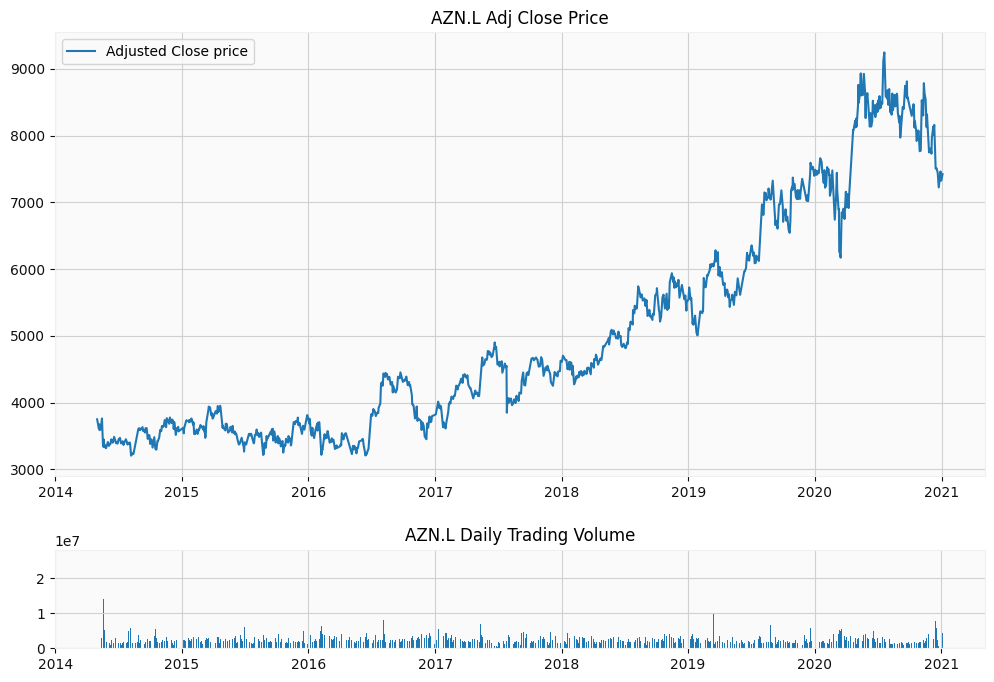

In [ ]:
# Plot Adjusted Close price and Volume

top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4) 
top.plot(azn_stock_df.index, azn_stock_df['Adj Close'], label = 'Adjusted Close price') 
plt.title('AZN.L Adj Close Price') 
plt.legend(loc=2) 
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4) 
bottom.bar(azn_stock_df.index, azn_stock_df["Volume"]) 
plt.title('AZN.L Daily Trading Volume') 
plt.gcf().set_size_inches(12,8) 
plt.subplots_adjust(hspace=0.75)

## 6. Merge Stock and Sentiment Dataframes on Date

In [ ]:
# Merge data sets on date
merge = azn_stock_df.merge(azn_news_df_combined, how='inner', left_index=True, right_index=True)


In [ ]:
# Show merged data set
merge

,Open,High,Low,Close,Adj Close,Volume,ticker,publish_date,title,body_text,url,neg,neu,pos,compound,news_combined
Date,,,,,,,,,,,,,,,,
2014-05-02,4825.0,4946.410156,4716.500000,4808.0,3750.035645,8406892,AZN.L,2014-05-02,Astrazeneca rejects latest Pfizer approach,Astrazeneca rejects latest Pfizer approach\n\n...,https://uk.investing.com//news/stock-market-ne...,0.172,0.782,0.047,-0.9169,Astrazeneca rejects latest Pfizer approach\n\n...
2014-05-06,4735.0,4762.500000,4657.500000,4677.5,3648.251709,3705878,AZN.L,2014-05-06,M&A frenzy in healthcare sector,(Reuters) - With several multi-billion dollar ...,https://uk.investing.com//news/stock-market-ne...,0.037,0.853,0.109,0.9928,(Reuters) - With several multi-billion dollar ...
2014-05-07,4622.0,4664.000000,4608.529785,4631.0,3611.983154,3988894,AZN.L,2014-05-07,Pfizer says AstraZeneca takeover would benefit...,LONDON (Reuters) - Pfizer ( ) sought to allay ...,https://uk.investing.com//news/stock-market-ne...,0.081,0.784,0.135,0.9509,LONDON (Reuters) - Pfizer ( ) sought to allay ...
2014-05-08,4630.0,4735.000000,4630.000000,4713.0,3675.940430,3380811,AZN.L,2014-05-08,EU likely to block any UK intervention in Astr...,By Kate Holton\n\nLONDON (Reuters) - The Europ...,https://uk.investing.com//news/economic-indica...,0.030,0.904,0.066,0.9115,By Kate Holton\n\nLONDON (Reuters) - The Europ...
2014-05-09,4665.0,4678.000000,4598.500000,4600.5,3588.194092,4069204,AZN.L,2014-05-09,Britain wants binding pledges from Pfizer on A...,Britain wants binding pledges from Pfizer on A...,https://uk.investing.com//news/economic-indica...,0.000,0.932,0.068,0.7430,Britain wants binding pledges from Pfizer on A...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,7307.0,7324.000000,7196.000000,7224.0,7224.000000,1588406,AZN.L,2020-12-23,AstraZeneca/Oxford vaccine might be approved w...,"“I would expect some news pretty shortly, I do...",https://invst.ly/t8hlp,0.053,0.883,0.064,0.7906,"“I would expect some news pretty shortly, I do..."
2020-12-29,7509.0,7578.240234,7440.000000,7462.0,7462.000000,2984828,AZN.L,2020-12-29,AstraZeneca shares rise as University of Oxfor...,A new study has indicated that 2mln people a w...,https://invst.ly/ta92r,0.027,0.878,0.095,0.9926,A new study has indicated that 2mln people a w...
2020-12-30,7570.0,7598.000000,7400.000000,7401.0,7401.000000,2290546,AZN.L,2020-12-30,The Daily Biotech Pulse: Osmotica Faces Second...,Here's a roundup of top developments in the bi...,https://invst.ly/tao66,0.036,0.862,0.102,0.9961,Here's a roundup of top developments in the bi...


In [ ]:
# Save merged DataFrame

merge.to_csv("azn_news_stock_merge_20210107.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
# Show first row in combined news column

merge['news_combined'].iloc[0]

'Astrazeneca rejects latest Pfizer approach\n\nStock Markets May 02, 2014 11:48\n\nLONDON (Reuters) - AstraZeneca\'s ( ) board said on Friday it had rejected an improved $106 billion (62.82 billion pounds) takeover offer from U.S. drugmaker Pfizer ( ), saying the bid which was announced just hours ago undervalued the firm. "Pfizer\'s proposal would dramatically dilute AstraZeneca shareholders\' exposure to our unique pipeline and would create risks around its delivery," Chairman Leif Johansson said. "As such, the board has no hesitation in rejecting the proposal." (Reporting by Kate Holton; editing by Sarah Young)\n\nAstrazeneca rejects latest Pfizer approach\n\nRelated Articles LONDON (Reuters) - Britain\'s government said it was considering whether reassurances made by Pfizer ( ) over its potential takeover of AstraZeneca ( ) offered sufficient protection to maintain the country\'s life sciences sector and related jobs.\n\nPfizer said earlier on Friday it had written to Prime Ministe

In [ ]:
# Iterate over rows in combined news column

for index, row in merge.iterrows(): 
    print (row["news_combined"])

Astrazeneca rejects latest Pfizer approach

Stock Markets May 02, 2014 11:48

LONDON (Reuters) - AstraZeneca's ( ) board said on Friday it had rejected an improved $106 billion (62.82 billion pounds) takeover offer from U.S. drugmaker Pfizer ( ), saying the bid which was announced just hours ago undervalued the firm. "Pfizer's proposal would dramatically dilute AstraZeneca shareholders' exposure to our unique pipeline and would create risks around its delivery," Chairman Leif Johansson said. "As such, the board has no hesitation in rejecting the proposal." (Reporting by Kate Holton; editing by Sarah Young)

Astrazeneca rejects latest Pfizer approach

Related Articles LONDON (Reuters) - Britain's government said it was considering whether reassurances made by Pfizer ( ) over its potential takeover of AstraZeneca ( ) offered sufficient protection to maintain the country's life sciences sector and related jobs.

Pfizer said earlier on Friday it had written to Prime Minister David Cameron 

### Clean data in combined news column

Strip newline escape sequence (\n), unwanted punctuation and backslashes.  

In [ ]:
# Create empty list to append cleaned data from combined news column

clean_news = []

for i in range(0, len(merge["news_combined"])): 
    clean_news.append(re.sub("\n", ' ', merge["news_combined"][i]))  # replace n\ with ' '
    clean_news[i] = re.sub(r'[^\w\d\s\']+', '', clean_news[i]) # remove unwanted punctuation and \'


In [ ]:
# Show first row in cleaned combined news column

clean_news[0]

"Astrazeneca rejects latest Pfizer approach  Stock Markets May 02 2014 1148  LONDON Reuters  AstraZeneca's   board said on Friday it had rejected an improved 106 billion 6282 billion pounds takeover offer from US drugmaker Pfizer   saying the bid which was announced just hours ago undervalued the firm Pfizer's proposal would dramatically dilute AstraZeneca shareholders' exposure to our unique pipeline and would create risks around its delivery Chairman Leif Johansson said As such the board has no hesitation in rejecting the proposal Reporting by Kate Holton editing by Sarah Young  Astrazeneca rejects latest Pfizer approach  Related Articles LONDON Reuters  Britain's government said it was considering whether reassurances made by Pfizer   over its potential takeover of AstraZeneca   offered sufficient protection to maintain the country's life sciences sector and related jobs  Pfizer said earlier on Friday it had written to Prime Minister David Cameron pledging to retain British jobs and

In [ ]:
# Add cleaned news column to merged data set

merge['news_cleaned'] = clean_news


merge['news_cleaned'][0]

"Astrazeneca rejects latest Pfizer approach  Stock Markets May 02 2014 1148  LONDON Reuters  AstraZeneca's   board said on Friday it had rejected an improved 106 billion 6282 billion pounds takeover offer from US drugmaker Pfizer   saying the bid which was announced just hours ago undervalued the firm Pfizer's proposal would dramatically dilute AstraZeneca shareholders' exposure to our unique pipeline and would create risks around its delivery Chairman Leif Johansson said As such the board has no hesitation in rejecting the proposal Reporting by Kate Holton editing by Sarah Young  Astrazeneca rejects latest Pfizer approach  Related Articles LONDON Reuters  Britain's government said it was considering whether reassurances made by Pfizer   over its potential takeover of AstraZeneca   offered sufficient protection to maintain the country's life sciences sector and related jobs  Pfizer said earlier on Friday it had written to Prime Minister David Cameron pledging to retain British jobs and

In [ ]:
# Show head of merged DataFrame

merge.head()

,Open,High,Low,Close,Adj Close,Volume,ticker,publish_date,title,body_text,url,neg,neu,pos,compound,news_combined,news_cleaned
Date,,,,,,,,,,,,,,,,,
2014-05-02,4825.0,4946.410156,4716.500000,4808.0,3750.035645,8406892,AZN.L,2014-05-02,Astrazeneca rejects latest Pfizer approach,Astrazeneca rejects latest Pfizer approach\n\n...,https://uk.investing.com//news/stock-market-ne...,0.172,0.782,0.047,-0.9169,Astrazeneca rejects latest Pfizer approach\n\n...,Astrazeneca rejects latest Pfizer approach St...
2014-05-06,4735.0,4762.500000,4657.500000,4677.5,3648.251709,3705878,AZN.L,2014-05-06,M&A frenzy in healthcare sector,(Reuters) - With several multi-billion dollar ...,https://uk.investing.com//news/stock-market-ne...,0.037,0.853,0.109,0.9928,(Reuters) - With several multi-billion dollar ...,Reuters With several multibillion dollar deal...
2014-05-07,4622.0,4664.000000,4608.529785,4631.0,3611.983154,3988894,AZN.L,2014-05-07,Pfizer says AstraZeneca takeover would benefit...,LONDON (Reuters) - Pfizer ( ) sought to allay ...,https://uk.investing.com//news/stock-market-ne...,0.081,0.784,0.135,0.9509,LONDON (Reuters) - Pfizer ( ) sought to allay ...,LONDON Reuters Pfizer sought to allay fears...
2014-05-08,4630.0,4735.000000,4630.000000,4713.0,3675.940430,3380811,AZN.L,2014-05-08,EU likely to block any UK intervention in Astr...,By Kate Holton\n\nLONDON (Reuters) - The Europ...,https://uk.investing.com//news/economic-indica...,0.030,0.904,0.066,0.9115,By Kate Holton\n\nLONDON (Reuters) - The Europ...,By Kate Holton LONDON Reuters The European C...
2014-05-09,4665.0,4678.000000,4598.500000,4600.5,3588.194092,4069204,AZN.L,2014-05-09,Britain wants binding pledges from Pfizer on A...,Britain wants binding pledges from Pfizer on A...,https://uk.investing.com//news/economic-indica...,0.000,0.932,0.068,0.7430,Britain wants binding pledges from Pfizer on A...,Britain wants binding pledges from Pfizer on A...


In [ ]:
# Save merged DataFrame

merge.to_csv("azn__merge_cleaned_20210107.csv", sep=',', encoding='utf-8', header=True)

## 7. Sentiment Analysis

TextBlob will be used to get subjectivity and polarity scores for the cleaned and merged news data. Polarity is a float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgement whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1] where 0 is objective and 1 is subjective.

In [ ]:
# Create function to get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
# Create new columns
merge['subjectivity'] = merge['news_cleaned'].apply(getSubjectivity)
merge['polarity'] = merge['news_cleaned'].apply(getPolarity)

In [ ]:
# Show new columns
merge.head(3)

,Open,High,Low,Close,Adj Close,Volume,ticker,publish_date,title,body_text,url,neg,neu,pos,compound,news_combined,news_cleaned,subjectivity,polarity
Date,,,,,,,,,,,,,,,,,,,
2014-05-02,4825.0,4946.410156,4716.500000,4808.0,3750.035645,8406892,AZN.L,2014-05-02,Astrazeneca rejects latest Pfizer approach,Astrazeneca rejects latest Pfizer approach\n\n...,https://uk.investing.com//news/stock-market-ne...,0.172,0.782,0.047,-0.9169,Astrazeneca rejects latest Pfizer approach\n\n...,Astrazeneca rejects latest Pfizer approach St...,0.418864,0.087500
2014-05-06,4735.0,4762.500000,4657.500000,4677.5,3648.251709,3705878,AZN.L,2014-05-06,M&A frenzy in healthcare sector,(Reuters) - With several multi-billion dollar ...,https://uk.investing.com//news/stock-market-ne...,0.037,0.853,0.109,0.9928,(Reuters) - With several multi-billion dollar ...,Reuters With several multibillion dollar deal...,0.363764,0.048624
2014-05-07,4622.0,4664.000000,4608.529785,4631.0,3611.983154,3988894,AZN.L,2014-05-07,Pfizer says AstraZeneca takeover would benefit...,LONDON (Reuters) - Pfizer ( ) sought to allay ...,https://uk.investing.com//news/stock-market-ne...,0.081,0.784,0.135,0.9509,LONDON (Reuters) - Pfizer ( ) sought to allay ...,LONDON Reuters Pfizer sought to allay fears...,0.440212,0.063364


In [ ]:
# Show shape of DataFrame
merge.shape

(564, 19)

In [ ]:
# Save DataFrame with subjectivity and polarity scores
merge.to_csv("azn__merge_cleaned_subj_pol_20210107.csv", sep=',', encoding='utf-8', header=True)

## 9. Feature engineering

We will calculate whether the next day Adjusted Close price increased/held or decreased and label these as 1 and 0 respectively to build and train machine learning classifier models to predict price direction based on sentiment.

In [ ]:
# Create copy of stock data

azn_stock_df_label = azn_stock_df.copy()
azn_stock_df_label

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-05-02,4825.0,4946.410156,4716.500000,4808.0,3750.035645,8406892
2014-05-06,4735.0,4762.500000,4657.500000,4677.5,3648.251709,3705878
2014-05-07,4622.0,4664.000000,4608.529785,4631.0,3611.983154,3988894
2014-05-08,4630.0,4735.000000,4630.000000,4713.0,3675.940430,3380811
2014-05-09,4665.0,4678.000000,4598.500000,4600.5,3588.194092,4069204
...,...,...,...,...,...,...
2020-12-24,7250.0,7326.000000,7217.000000,7223.0,7223.000000,744212
2020-12-29,7509.0,7578.240234,7440.000000,7462.0,7462.000000,2984828
2020-12-30,7570.0,7598.000000,7400.000000,7401.0,7401.000000,2290546


In [ ]:
# "1" when AZN Adj Close value rose or stayed as the same;
# "0" when AZN Adj Close value decreased.

azn_stock_df_label['Adj Close Next'] = azn_stock_df_label['Adj Close'].shift(-1)
azn_stock_df_label['Label'] = azn_stock_df_label.apply(lambda x: 1 if (x['Adj Close Next']>= x['Adj Close']) else 0, axis =1)

azn_stock_df_label[['Adj Close', 'Adj Close Next', 'Label']].head(5)

,Adj Close,Adj Close Next,Label
Date,,,
2014-05-02,3750.035645,3648.251709,0
2014-05-06,3648.251709,3611.983154,0
2014-05-07,3611.983154,3675.940430,1
2014-05-08,3675.940430,3588.194092,0
2014-05-09,3588.194092,3595.604248,1


In [ ]:
# Save DataFrame

azn_stock_df_label.to_pickle("azn_stock_df_labels_20210107.pkl")

In [ ]:
azn_stock_df_label.to_csv("azn_stock_df_label_20210107.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
# Show Adj Close Next and Label with Date

azn_stock_df_label_adj_nxt = azn_stock_df_label[['Adj Close Next', 'Label']]
azn_stock_df_label_adj_nxt

,Adj Close Next,Label
Date,,
2014-05-02,3648.251709,0
2014-05-06,3611.983154,0
2014-05-07,3675.940430,1
2014-05-08,3588.194092,0
2014-05-09,3595.604248,1
...,...,...
2020-12-24,7462.000000,1
2020-12-29,7401.000000,0
2020-12-30,7324.000000,0


In [ ]:
# Drop NaN row

azn_stock_df_label_adj_nxt = azn_stock_df_label_adj_nxt.dropna()
azn_stock_df_label_adj_nxt

,Adj Close Next,Label
Date,,
2014-05-02,3648.251709,0
2014-05-06,3611.983154,0
2014-05-07,3675.940430,1
2014-05-08,3588.194092,0
2014-05-09,3595.604248,1
...,...,...
2020-12-23,7223.000000,0
2020-12-24,7462.000000,1
2020-12-29,7401.000000,0


In [ ]:
# Merge DataFrames on date
merge2 = azn_stock_df.merge(azn_stock_df_label_adj_nxt, how='inner', left_index=True, right_index=True)

In [ ]:
# Drop NaN row and show merged DataFrame
merge2 = merge2.dropna()
merge2

,Open,High,Low,Close,Adj Close,Volume,Adj Close Next,Label
Date,,,,,,,,
2014-05-02,4825.0,4946.410156,4716.500000,4808.0,3750.035645,8406892,3648.251709,0
2014-05-06,4735.0,4762.500000,4657.500000,4677.5,3648.251709,3705878,3611.983154,0
2014-05-07,4622.0,4664.000000,4608.529785,4631.0,3611.983154,3988894,3675.940430,1
2014-05-08,4630.0,4735.000000,4630.000000,4713.0,3675.940430,3380811,3588.194092,0
2014-05-09,4665.0,4678.000000,4598.500000,4600.5,3588.194092,4069204,3595.604248,1
...,...,...,...,...,...,...,...,...
2020-12-23,7307.0,7324.000000,7196.000000,7224.0,7224.000000,1588406,7223.000000,0
2020-12-24,7250.0,7326.000000,7217.000000,7223.0,7223.000000,744212,7462.000000,1
2020-12-29,7509.0,7578.240234,7440.000000,7462.0,7462.000000,2984828,7401.000000,0


In [ ]:
# Save DataFrame
merge2.to_csv("azn_prices_labels_20210107.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
merge2.to_pickle("azn_prices_labels_20210107.pkl")

In [ ]:
# Merge next day Adjusted Close price and Label with combined stock data and sentiment DataFrame

merge3 = azn_stock_df_label_adj_nxt.merge(merge, how='inner', left_index=True, right_index=True)
merge3

,Adj Close Next,Label,Open,High,Low,Close,Adj Close,Volume,ticker,publish_date,title,body_text,url,neg,neu,pos,compound,news_combined,news_cleaned,subjectivity,polarity
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-02,3648.251709,0,4825.0,4946.410156,4716.500000,4808.0,3750.035645,8406892,AZN.L,2014-05-02,Astrazeneca rejects latest Pfizer approach,Astrazeneca rejects latest Pfizer approach\n\n...,https://uk.investing.com//news/stock-market-ne...,0.172,0.782,0.047,-0.9169,Astrazeneca rejects latest Pfizer approach\n\n...,Astrazeneca rejects latest Pfizer approach St...,0.418864,0.087500
2014-05-06,3611.983154,0,4735.0,4762.500000,4657.500000,4677.5,3648.251709,3705878,AZN.L,2014-05-06,M&A frenzy in healthcare sector,(Reuters) - With several multi-billion dollar ...,https://uk.investing.com//news/stock-market-ne...,0.037,0.853,0.109,0.9928,(Reuters) - With several multi-billion dollar ...,Reuters With several multibillion dollar deal...,0.363764,0.048624
2014-05-07,3675.940430,1,4622.0,4664.000000,4608.529785,4631.0,3611.983154,3988894,AZN.L,2014-05-07,Pfizer says AstraZeneca takeover would benefit...,LONDON (Reuters) - Pfizer ( ) sought to allay ...,https://uk.investing.com//news/stock-market-ne...,0.081,0.784,0.135,0.9509,LONDON (Reuters) - Pfizer ( ) sought to allay ...,LONDON Reuters Pfizer sought to allay fears...,0.440212,0.063364
2014-05-08,3588.194092,0,4630.0,4735.000000,4630.000000,4713.0,3675.940430,3380811,AZN.L,2014-05-08,EU likely to block any UK intervention in Astr...,By Kate Holton\n\nLONDON (Reuters) - The Europ...,https://uk.investing.com//news/economic-indica...,0.030,0.904,0.066,0.9115,By Kate Holton\n\nLONDON (Reuters) - The Europ...,By Kate Holton LONDON Reuters The European C...,0.344073,0.104754
2014-05-09,3595.604248,1,4665.0,4678.000000,4598.500000,4600.5,3588.194092,4069204,AZN.L,2014-05-09,Britain wants binding pledges from Pfizer on A...,Britain wants binding pledges from Pfizer on A...,https://uk.investing.com//news/economic-indica...,0.000,0.932,0.068,0.7430,Britain wants binding pledges from Pfizer on A...,Britain wants binding pledges from Pfizer on A...,0.310985,0.167045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,7224.000000,0,7364.0,7396.709961,7313.000000,7328.0,7328.000000,2518823,AZN.L,2020-12-22,UPDATE 1-UK Stocks-Factors to watch on Dec 22,© Reuters.\n\nDec 22 (Reuters) - Britain's FTS...,https://uk.investing.com//news/stock-market-ne...,0.146,0.796,0.058,-0.9764,© Reuters.\n\nDec 22 (Reuters) - Britain's FTS...,Reuters Dec 22 Reuters Britain's FTSE 100 f...,0.368144,0.047204
2020-12-23,7223.000000,0,7307.0,7324.000000,7196.000000,7224.0,7224.000000,1588406,AZN.L,2020-12-23,AstraZeneca/Oxford vaccine might be approved w...,"“I would expect some news pretty shortly, I do...",https://invst.ly/t8hlp,0.053,0.883,0.064,0.7906,"“I would expect some news pretty shortly, I do...",I would expect some news pretty shortly I doub...,0.428364,0.066097
2020-12-29,7401.000000,0,7509.0,7578.240234,7440.000000,7462.0,7462.000000,2984828,AZN.L,2020-12-29,AstraZeneca shares rise as University of Oxfor...,A new study has indicated that 2mln people a w...,https://invst.ly/ta92r,0.027,0.878,0.095,0.9926,A new study has indicated that 2mln people a w...,A new study has indicated that 2mln people a w...,0.423049,0.103666


In [ ]:
# Save merged DataFrame

merge3.to_csv("azn_prices_labels_news_20210107.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
merge3.to_pickle("azn_prices_labels_news_20210107.pkl")

In [ ]:
merge3 = pd.read_pickle("azn_prices_labels_news_20210107.pkl")

In [ ]:
# Collapse data set to keep relevant stock price and sentiment score columns only

keep_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'subjectivity', 'polarity', 'compound', 'neg',	'neu',	'pos', 'Label']
df =  merge3[keep_columns]
df

,Open,High,Low,Close,Adj Close,Volume,subjectivity,polarity,compound,neg,neu,pos,Label
Date,,,,,,,,,,,,,
2014-05-02,4825.0,4946.410156,4716.500000,4808.0,3750.035645,8406892,0.418864,0.087500,-0.9169,0.172,0.782,0.047,0
2014-05-06,4735.0,4762.500000,4657.500000,4677.5,3648.251709,3705878,0.363764,0.048624,0.9928,0.037,0.853,0.109,0
2014-05-07,4622.0,4664.000000,4608.529785,4631.0,3611.983154,3988894,0.440212,0.063364,0.9509,0.081,0.784,0.135,1
2014-05-08,4630.0,4735.000000,4630.000000,4713.0,3675.940430,3380811,0.344073,0.104754,0.9115,0.030,0.904,0.066,0
2014-05-09,4665.0,4678.000000,4598.500000,4600.5,3588.194092,4069204,0.310985,0.167045,0.7430,0.000,0.932,0.068,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,7364.0,7396.709961,7313.000000,7328.0,7328.000000,2518823,0.368144,0.047204,-0.9764,0.146,0.796,0.058,0
2020-12-23,7307.0,7324.000000,7196.000000,7224.0,7224.000000,1588406,0.428364,0.066097,0.7906,0.053,0.883,0.064,0
2020-12-29,7509.0,7578.240234,7440.000000,7462.0,7462.000000,2984828,0.423049,0.103666,0.9926,0.027,0.878,0.095,0


## 10. Modelling

Split the data in feature matrix (X) and target vector (y).


In [ ]:
# Create feature data set
X = df
X = np.array(X.drop(['Label'], 1))

# Create target data set
y = np.array(df['Label'])

We will split the data into train and test sets to verify predictions. Time series data cannot be split randomly as this would introduce look-ahead bias so the first 80% will be the training set and the last 20% the test set.

In [ ]:
# Split data into 80% training and 20% testing data sets

split = int(0.8*len(df))

In [ ]:
X_train = X[0:split]
y_train = y[0:split]

X_test = X[split:]
y_test = y[split:]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(450, 12)
(450,)
(113, 12)
(113,)


In [ ]:
# Create and train the model
model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [ ]:
# Show model's predictions
predictions = model.predict(X_test)
predictions

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1])

In [ ]:
y_test

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1])

In [ ]:
# Show model metrics 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.52      0.41      0.46        63
           1       0.41      0.52      0.46        50

    accuracy                           0.46       113
   macro avg       0.47      0.47      0.46       113
weighted avg       0.47      0.46      0.46       113



In [ ]:
# Show model's predictions - OLD
predictions = model.predict(X_test)
predictions

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1])

In [ ]:
y_test  # OLD

array([1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0])

In [ ]:
# Show model metrics - OLD
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.53      0.65      0.58        57
           1       0.53      0.41      0.46        56

    accuracy                           0.53       113
   macro avg       0.53      0.53      0.52       113
weighted avg       0.53      0.53      0.52       113



### Feature scaling

We will standardise the data using scikit-learn's preprocessing.scale() algorithm so that it is all on one scale.

In [ ]:
# Standardise X's
X_train = scale(X_train)
X_test = scale(X_test)

### Create function for confusion matrix to visualise performance

In [ ]:
# Function for confusion matrix

def plot_confusion_matrix(y_true, y_pred, labels=["Decrease", "Increase"], 
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

### Create dictionary of classifiers to train and predict on


-------------- LinearDiscriminantAnalysis ---------------



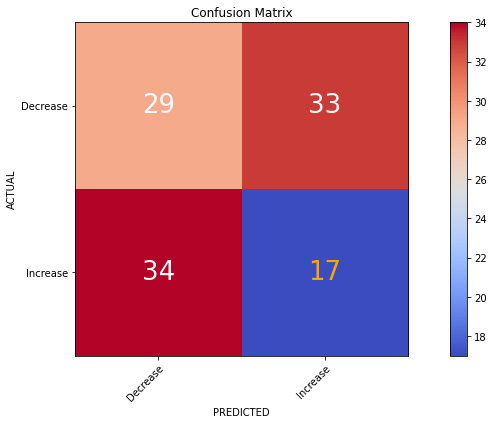

              precision    recall  f1-score   support

    Decrease       0.46      0.47      0.46        62
    Increase       0.34      0.33      0.34        51

    accuracy                           0.41       113
   macro avg       0.40      0.40      0.40       113
weighted avg       0.41      0.41      0.41       113


-------------- SVM Classification ---------------



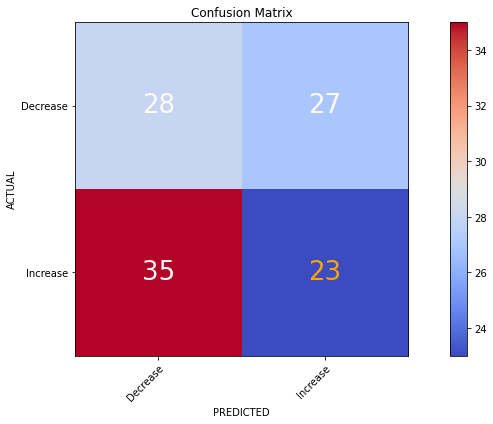

              precision    recall  f1-score   support

    Decrease       0.44      0.51      0.47        55
    Increase       0.46      0.40      0.43        58

    accuracy                           0.45       113
   macro avg       0.45      0.45      0.45       113
weighted avg       0.45      0.45      0.45       113


-------------- SGDClassifier ---------------



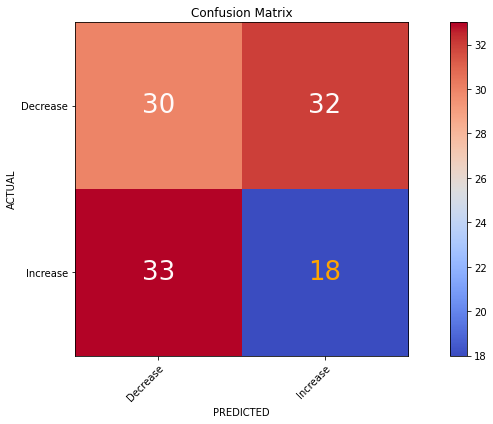

              precision    recall  f1-score   support

    Decrease       0.48      0.48      0.48        62
    Increase       0.36      0.35      0.36        51

    accuracy                           0.42       113
   macro avg       0.42      0.42      0.42       113
weighted avg       0.42      0.42      0.42       113


-------------- KNeighborsClassifier ---------------



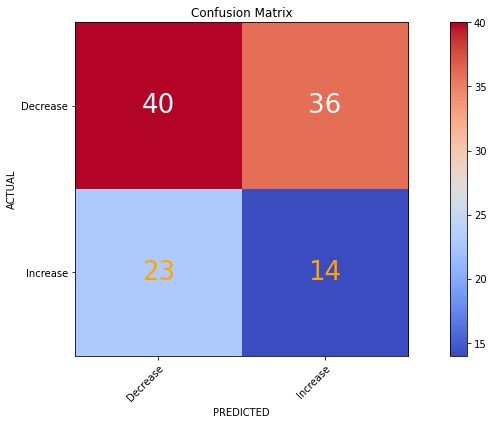

              precision    recall  f1-score   support

    Decrease       0.63      0.53      0.58        76
    Increase       0.28      0.38      0.32        37

    accuracy                           0.48       113
   macro avg       0.46      0.45      0.45       113
weighted avg       0.52      0.48      0.49       113


-------------- GaussianProcessClassifier ---------------



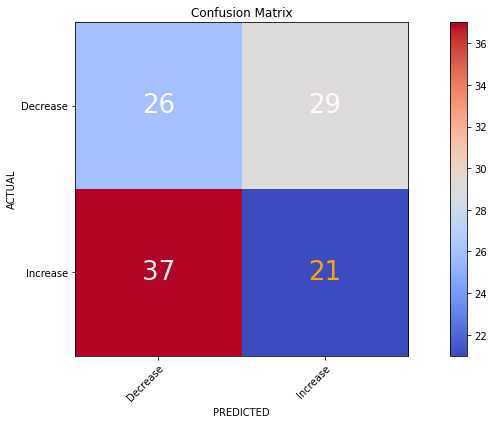

              precision    recall  f1-score   support

    Decrease       0.41      0.47      0.44        55
    Increase       0.42      0.36      0.39        58

    accuracy                           0.42       113
   macro avg       0.42      0.42      0.41       113
weighted avg       0.42      0.42      0.41       113


-------------- RandomForestClassifier ---------------



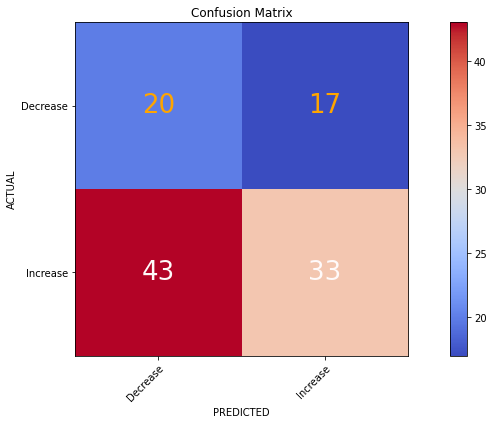

              precision    recall  f1-score   support

    Decrease       0.32      0.54      0.40        37
    Increase       0.66      0.43      0.52        76

    accuracy                           0.47       113
   macro avg       0.49      0.49      0.46       113
weighted avg       0.55      0.47      0.48       113



In [ ]:
# test models
models = {  'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
            'SVM Classification': SVC(),
            'SGDClassifier': SGDClassifier(loss="hinge", penalty="l2", max_iter=100),
            'KNeighborsClassifier':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClassifier': GaussianProcessClassifier(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=100)
            }

for model_name in models.keys():

    model = models[model_name]
    print('\n'+'--------------',model_name,'---------------'+'\n')
    model.fit(X_train,y_train)
    # Plot confusion matrix
    plot_confusion_matrix(model.predict(X_test),y_test, title="Confusion Matrix")
    np.set_printoptions(precision=1)
    plt.show()
    # Final Classification Report
    print(classification_report(model.predict(X_test),y_test, target_names=['Decrease', 'Increase']))

### Conclusion

The precision score is the 'exactness', or ability of the model to return only relevant instances. When a model makes a prediction, how often it is correct? 

It appears that the model which correctly predicted the increase in price most often was the Random Forest Classifier at 66%, and the K-Nearest Neighbours Classifier was best at predicting the decrease in price 63% of the time. 

None of the scores were particularly outstanding and further improvements might include updating the lexicon with words and sentiments from other more specialised sources such as the [Loughran-McDonald Financial Sentiment Word Lists](https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists). This would likely result in more accurate sentiment analysis as it was specifically built for financial text whereas VADER is more attuned to sentiments expressed in social media.
